In [5]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Import Libraries/Packages
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random
from skimage.io import imread

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model


from IPython.display import Audio


In [2]:
tt= r'C:\Users\hp\Downloads\Fr\test'
tr = r'C:\Users\hp\Downloads\Fr\train'


row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +"/" +expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
tr_count = count_exp(tr, 'train')
tt_count = count_exp(tt, 'test')
print(tr_count)
print(tt_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


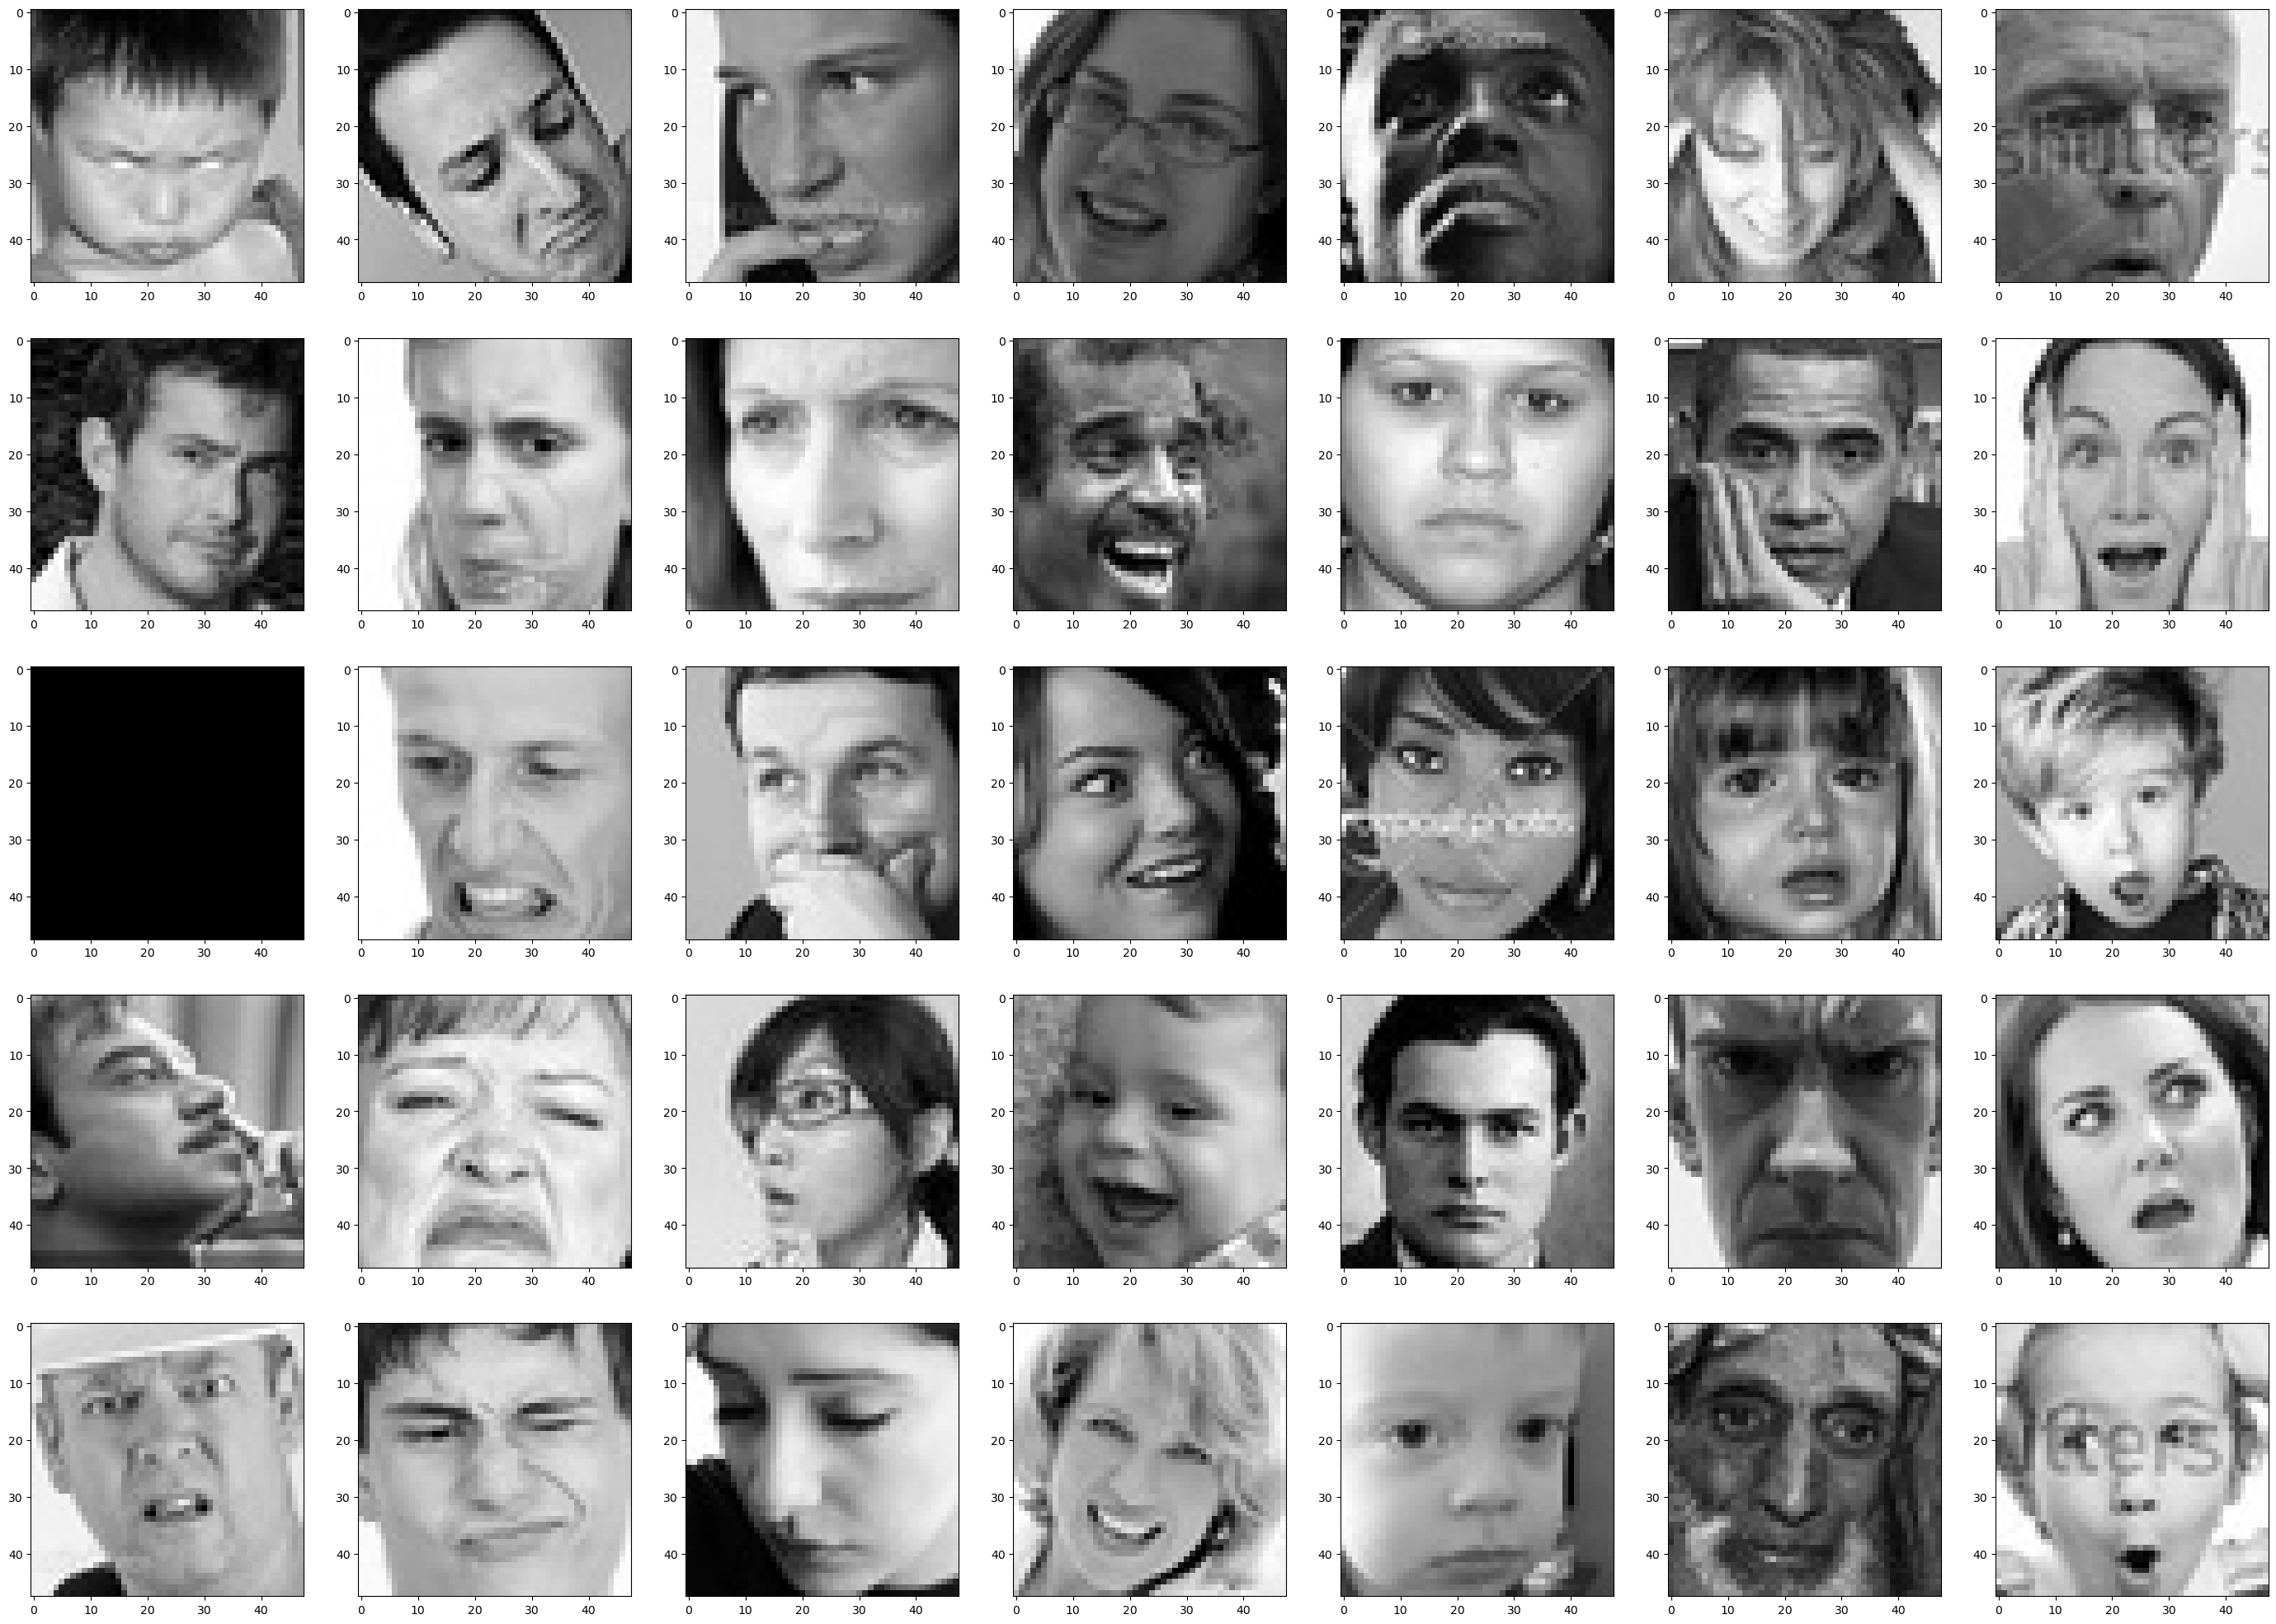

In [4]:
from skimage.io import imread
tt= r'C:\\Users\\hp\\Downloads\\Fr\\test\\'
tr = r'C:\\Users\\hp\\Downloads\\Fr\\train\\'
total_labels = len(os.listdir(tr))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(tr)):
        ax[x][y].imshow(imread(tr+v+'/'+os.listdir(tr+v)[x]), cmap='gray')

plt.show()

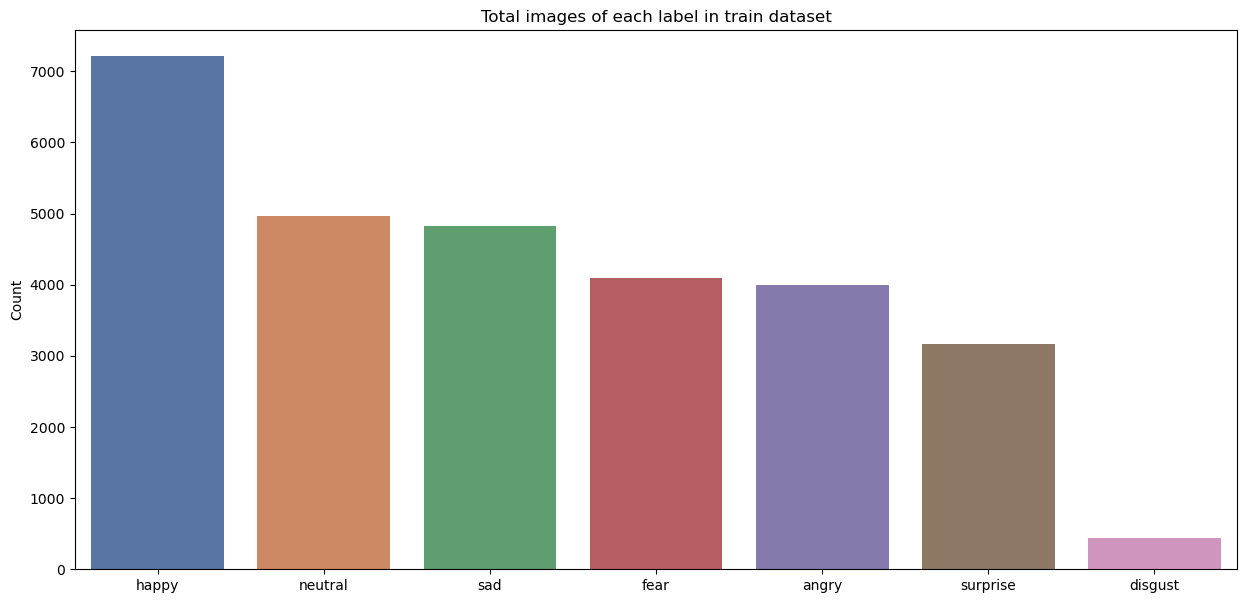

In [5]:
df = {}
for i in os.listdir(tr):
    directory = tr + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(15,7))
sns.barplot(x=df.index, y="total", palette="deep", data=df)
plt.ylabel("Count")
plt.title("Total images of each label in train dataset")
plt.show()

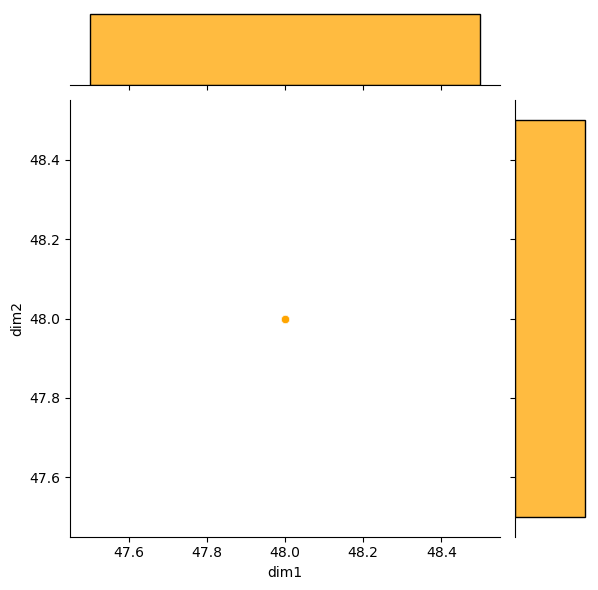

In [7]:
happy = os.listdir(tr+'happy/')
dim1, dim2 = [], []

for fimg in happy:
    img = imread(tr+'happy/'+fimg)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

df = pd.DataFrame({'dim1': dim1, 'dim2': dim2})
sns.jointplot(data=df, x='dim1', y='dim2', color='orange')
plt.show()
img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

In [8]:
# data pre processing
tr_pr = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

tt_pr = ImageDataGenerator(rescale=1/255)



tr_pred = tr_pr.flow_from_directory(directory=tr,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

tt_pred = tt_pr.flow_from_directory(directory=tt,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Building Model

In [9]:
# Create the Model
mod = Sequential()

mod.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
mod.add(BatchNormalization())
mod.add(MaxPooling2D(pool_size=(2,2)))
mod.add(Dropout(0.2))

mod.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
mod.add(BatchNormalization())
mod.add(MaxPooling2D(pool_size=(2,2)))
mod.add(Dropout(0.2))

mod.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
mod.add(BatchNormalization())
mod.add(MaxPooling2D(pool_size=(2,2)))
mod.add(Dropout(0.2))

mod.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
mod.add(BatchNormalization())
mod.add(MaxPooling2D(pool_size=(2,2)))
mod.add(Dropout(0.2))

mod.add(Flatten())

mod.add(Dense(512, activation='relu'))
mod.add(Dropout(0.2))

mod.add(Dense(1024, activation='relu'))
mod.add(Dropout(0.2))
mod.add(Dense(units=len(os.listdir(tr)), activation='softmax'))

mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       5

In [13]:
# Training and testing
mod.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
steps_per_epoch = tr_pred.n // tr_pred.batch_size
validation_steps = tt_pred.n // tt_pred.batch_size
num_epochs = 20

history = mod.fit(tr_pred,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=tt_pred,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - 476s 1s/step - loss: 1.8212 - accuracy: 0.2366 - val_loss: 1.9901 - val_accuracy: 0.2494
Epoch 2/20
448/448 [==============================] - 558s 1s/step - loss: 1.7962 - accuracy: 0.2470 - val_loss: 1.7771 - val_accuracy: 0.2653
Epoch 3/20
448/448 [==============================] - 514s 1s/step - loss: 1.7826 - accuracy: 0.2613 - val_loss: 1.7556 - val_accuracy: 0.2741
Epoch 4/20
448/448 [==============================] - 489s 1s/step - loss: 1.7640 - accuracy: 0.2719 - val_loss: 1.6939 - val_accuracy: 0.3103
Epoch 5/20
448/448 [==============================] - 483s 1s/step - loss: 1.7439 - accuracy: 0.2854 - val_loss: 1.6305 - val_accuracy: 0.3478
Epoch 6/20
448/448 [==============================] - 537s 1s/step - loss: 1.7207 - accuracy: 0.2998 - val_loss: 1.6586 - val_accuracy: 0.3506
Epoch 7/20
448/448 [==============================] - 768s 2s/step - loss: 1.6933 - accuracy: 0.3194 - val_loss: 1.6666 - val_accuracy: 0.3523

In [16]:
mod.save("mod.keras")

In [17]:
## Evaluating Model
test_loss, test_acc = mod.evaluate(tt_pred)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 13s 117ms/step - loss: 1.2046 - accuracy: 0.5346
validation accuracy : 53.45500111579895%
validation loss : 1.204595685005188


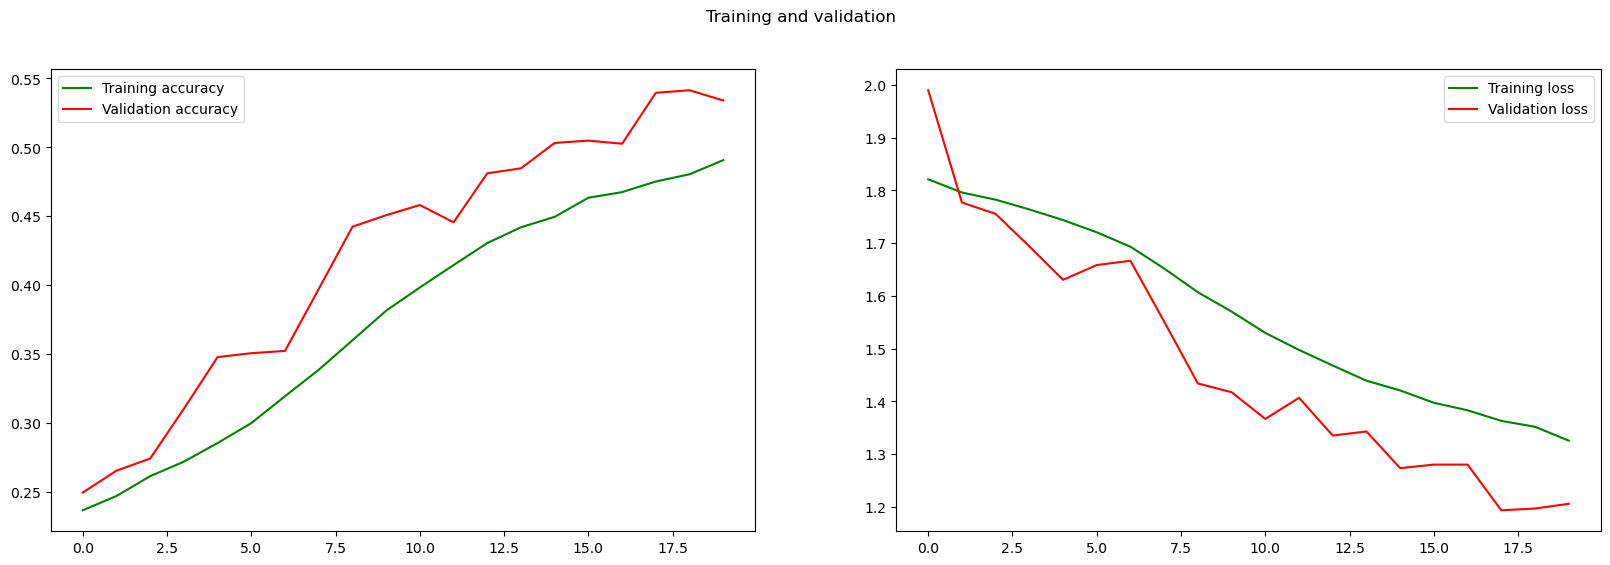

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

113/113 [==============================] - 14s 120ms/step
              precision    recall  f1-score   support

       angry       0.48      0.38      0.43       958
     disgust       0.00      0.00      0.00       111
        fear       0.39      0.14      0.21      1024
       happy       0.67      0.89      0.77      1774
     neutral       0.43      0.63      0.51      1233
         sad       0.44      0.29      0.35      1247
    surprise       0.58      0.74      0.65       831

    accuracy                           0.53      7178
   macro avg       0.43      0.44      0.41      7178
weighted avg       0.50      0.53      0.50      7178





C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


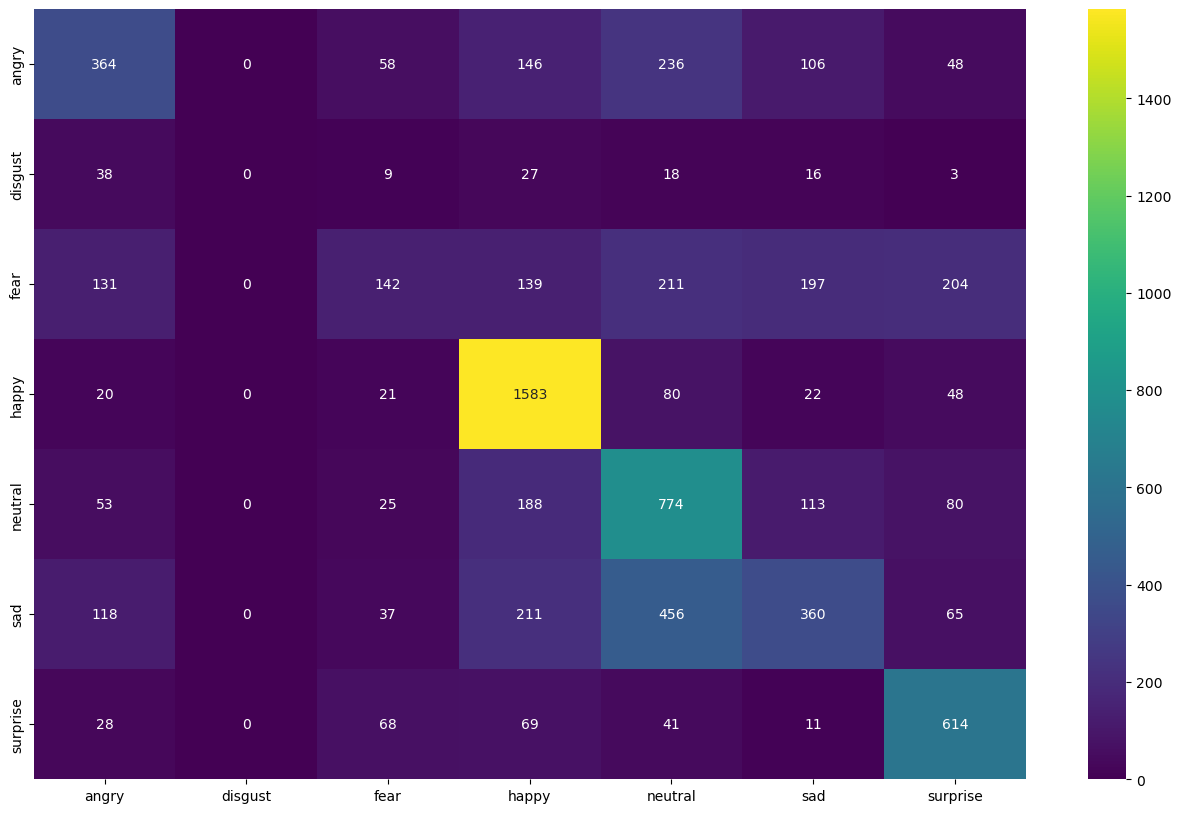

In [19]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(mod.predict(tt_pred), axis=-1)
print(classification_report(tt_pred.classes, y_pred, target_names=tt_pred.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(tt_pred.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=tt_pred.class_indices.keys(), yticklabels=tt_pred.class_indices.keys())
plt.show()

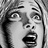

In [23]:
# Testing our model with new image
image = cv2.imread(r"C:\Users\hp\Downloads\Fr\test\fear\PublicTest_81993157.jpg")
from IPython.display import Image
Image(filename=r"C:\Users\hp\Downloads\Fr\test\fear\PublicTest_81993157.jpg")


In [24]:
import cv2
from tensorflow.python.keras.models import load_model
import os

# Load the trained model
mod = tf.keras.models.load_model("mod.keras",
                                   custom_objects={'Functional': tf.keras.models.Model})
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, convert to grayscale, and normalize
frame = cv2.resize(img, (48, 48), interpolation=cv2.INTER_LINEAR)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reshape the image dimension
gray = gray.reshape(1, 48, 48, 1)

# Output the prediction
preds = mod.predict(gray)[0]
label = EMOTIONS[preds.argmax()]
for (i, j) in zip(range(7), EMOTIONS):
    pres = preds[i]
    print("{:^10s}".format(j) + " prediction rate is   {0:.2f}%".format(pres))
print("\n\n The system considers this expression to be:", label)

1/1 [==============================] - 0s 141ms/step
  Angry    prediction rate is   0.42%
 Disgust   prediction rate is   0.00%
  Happy    prediction rate is   0.49%
   Sad     prediction rate is   0.05%
 Surprise  prediction rate is   0.00%
 Neutral   prediction rate is   0.00%


 The system considers this expression to be: Happy


In [29]:
import random
from IPython.display import Audio, display

if label == 'Angry':
    path = "C:\\Users\\hp\\Downloads\\Fr\\test\\Angry\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename="C:\\Users\\hp\\Downloads\\Judaai.mp3", autoplay=True)
    display(audio)

elif label == 'Disgust':
    path = "C:\\Users\\hp\\Downloads\\Fr\\test\\Disgust\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename="C:\\Users\\hp\\Downloads\\players.mp3",  autoplay=True)
    display(audio)

elif label == "Happy":
    path = "C:\\Users\\hp\\Downloads\\Fr\\test\\Happy\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename="C:\\Users\\hp\\Downloads\\wildest dream.mp3",  autoplay=True)
    display(audio)

elif label == 'Sad':
    path = "C:\\Users\\hp\\Downloads\\Fr\\test\\sad\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename="C:\\Users\\hp\\Downloads\\goodbye.mp3",  autoplay=True)
    display(audio)

elif label == 'Surprise':
    path = "C:\\Users\\hp\\Downloads\\Fr\\test\\surprise\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename="C:\\Users\\hp\\Downloads\\ik vaari.mp3" , autoplay=True)
    display(audio)

elif label == 'Neutral':
    path = "C:\\Users\\hp\\Downloads\\Fr\\test\\neutral\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename="C:\\Users\\hp\Downloads\\love story.mp3", autoplay=True)
    display(audio)

Now Playing: PrivateTest_42062459.jpg
